In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import signal
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from datetime import date, datetime, timedelta


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
alldata = pd.read_csv('../Data/data_for_datafig.csv')
alldata['Unnamed: 0'] = pd.to_datetime(alldata['Unnamed: 0'])
alldata.set_index('Unnamed: 0',inplace=True)

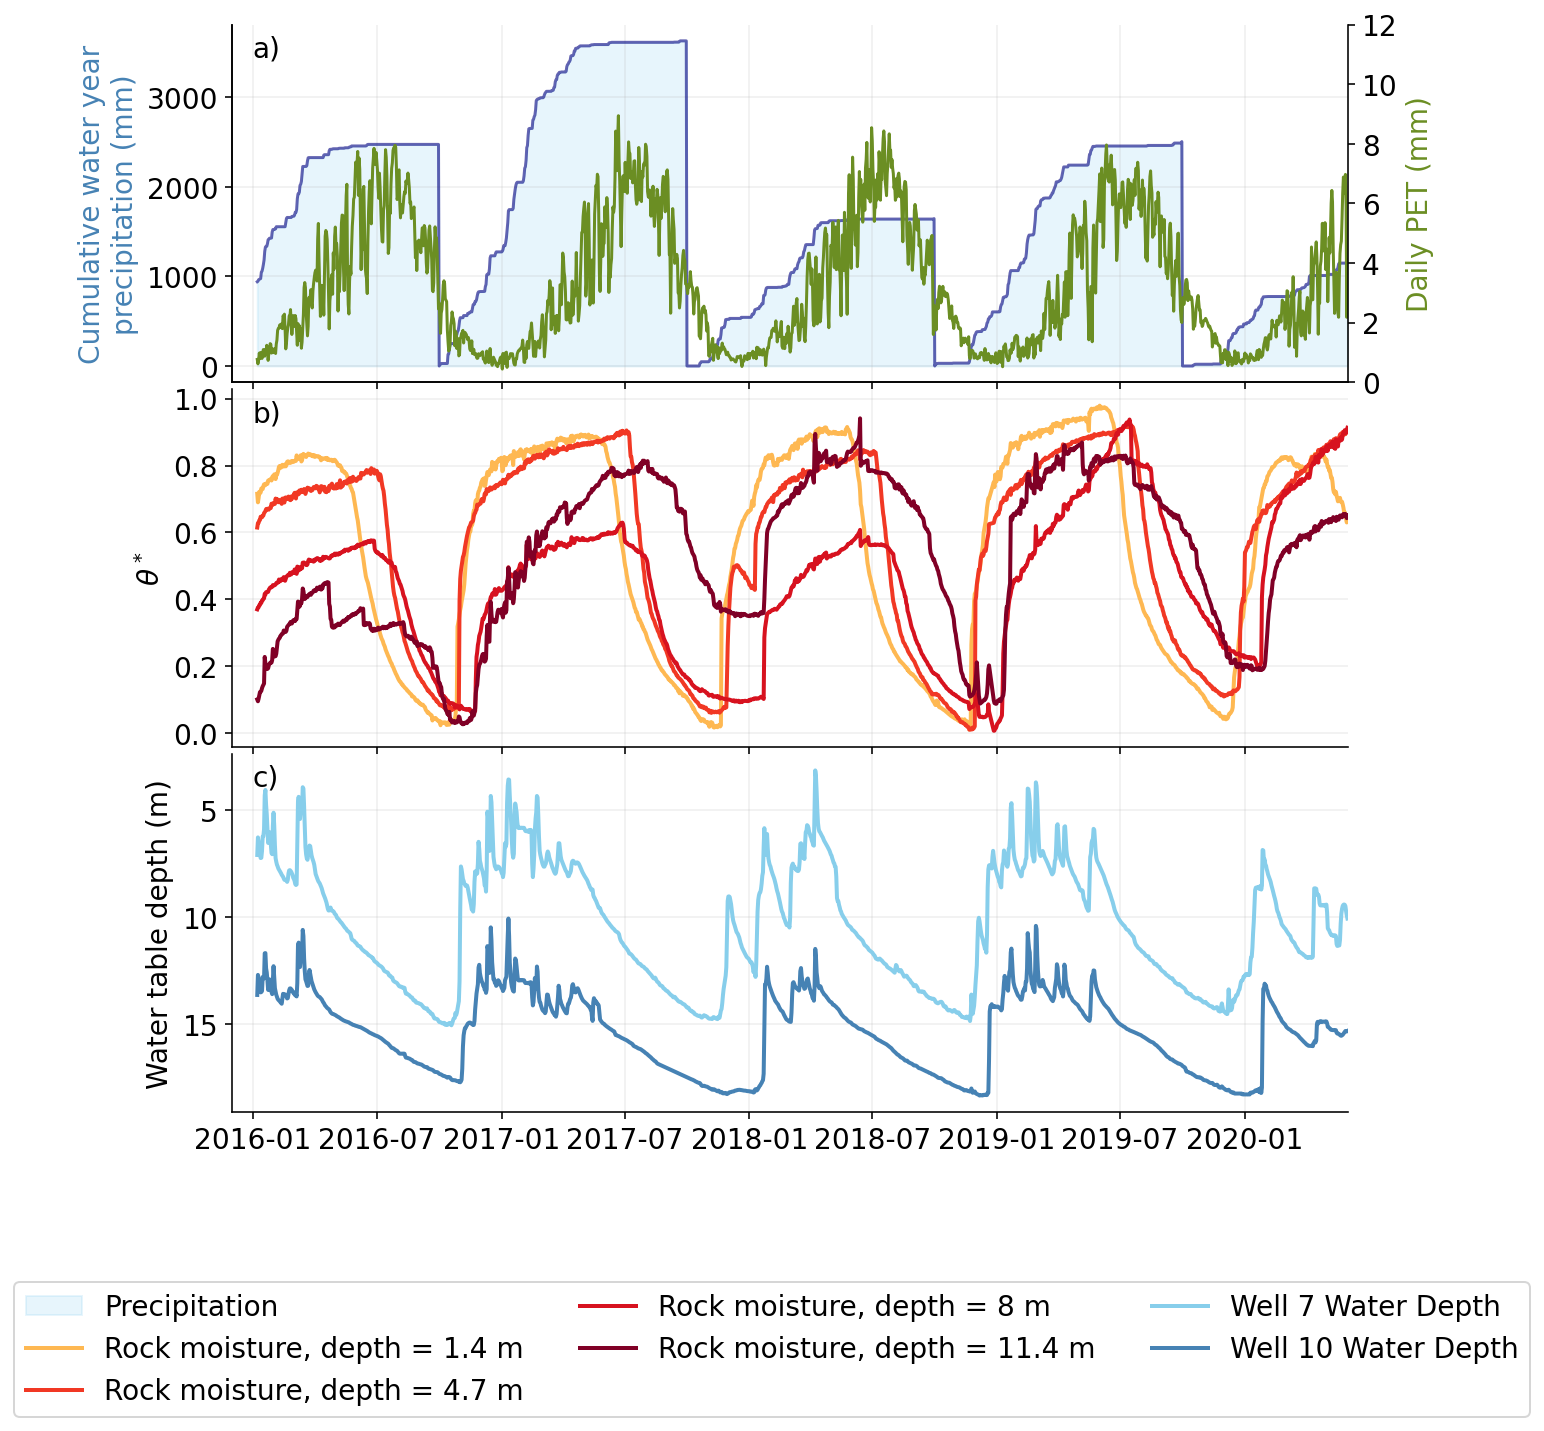

In [3]:
import matplotlib.transforms as mtransforms

#@title Stacked plot: Rock moisture, well levels, precipitation
import matplotlib.pylab as pl
plt.rcParams['font.size'] = 14
aports = ['A1', 'A2', 'A3','A4', 'A5', 'A6','A7']
asensors = [1.4, 2.9, 4.7, 6.4, 8, 9.7, 11.4]
colors = pl.cm.YlOrRd(np.linspace(0.25,1,7+1))


date_start = '12-1-2015'
date_end = '6-1-2020'


plt.rcParams["figure.facecolor"] = 'w'




fig, ax = plt.subplots(3,1, sharex=True, sharey= False,figsize=(10,10))
ax[0].grid(alpha=0.2)
ax[0].grid(True)

ax[0].plot(alldata.index, alldata['Rivendell_WY_Rain_mm'],color="navy",alpha=0.6)
pre = ax[0].fill_between(alldata.index, alldata['Rivendell_WY_Rain_mm'],
                         label = 'Precipitation', color="#89CFF0",alpha=0.2)
ax[0].set_ylabel('Cumulative water year\nprecipitation (mm)',c='steelblue')
ax[0].tick_params('x', labelbottom=False)
ax1 = ax[0].twinx()
ax1.plot(alldata.index,alldata.PET_mmd,c='olivedrab')
ax1.set_ylim(0,12)
ax1.set_ylabel('Daily PET (mm)',c='olivedrab')


lw=2
r1, = ax[1].plot(alldata.index, alldata['A1'], color=colors[1],label = 'Rock moisture, depth = 1.4 m',lw=lw)
r2, = ax[1].plot(alldata.index, alldata['A4'], color=colors[4], label = 'Rock moisture, depth = 4.7 m',lw=lw)
r3, = ax[1].plot(alldata.index, alldata['A5'], color=colors[5], label = 'Rock moisture, depth = 8 m',lw=lw)
r4, = ax[1].plot(alldata.index, alldata['A7'], color=colors[7],label = 'Rock moisture, depth = 11.4 m',lw=lw)

ax[1].grid(alpha=0.2)
ax[1].set_ylabel(r'$\theta^*$')
ax[1].set_xlim(pd.to_datetime(date_start), pd.to_datetime(date_end))

w10, = ax[2].plot(alldata.index, alldata['well_10_adjust']*-1, 
                  color='steelblue', linewidth=2, label='Well 10 Water Depth')
w7, = ax[2].plot(alldata.index, alldata['well_07_adjust']*-1, 
                 color='skyblue', linewidth=2, label='Well 7 Water Depth')



ax[2].invert_yaxis()
ax[2].grid(True, alpha=0.2)
ax[2].set_ylabel('Water table depth (m)')


plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.02)

items = [pre, r1, r2, r3, r4, w7, w10]
fig.legend(items, [item.get_label() for item in items],loc= 'center', bbox_to_anchor=(0.5, -0.04), ncol= 3)


labels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)',
         'j)','k)','l)','m)','n)','o)','p)','q)','r)',
          's)','t)','u)','v)']
for i,ax2 in enumerate(ax.flatten()):
    for side in ['top','right']:
        ax2.spines[side].set_visible(False)

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax2.text(0, 1, labels[i], transform=ax2.transAxes + trans,
             verticalalignment='top', )
ax1.spines['top'].set_visible(False)

plt.savefig('datafig_vms.png',format='png',dpi=300,bbox_inches='tight')